In [0]:
SANDBOX_NAME = 'fesc'# Sandbox Name
DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
#from sklearn.grid_search import GridSearchCV, ParameterGrid
#from sklearn.cluster import KMeans



## Lectura de datos

In [0]:
diabetes = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/diabetic_data.csv')
admission_source = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/admission_source_id.csv')
admission_type  = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/admission_type_id.csv')
discharge_disposition = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/discharge_disposition_id.csv')




### Comprobar correcta lectura de los datos

Analizamos cada tabla individual para ver que se han cargado bien los datos y para ver si hay nulos

In [0]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
#Analizamos si hay nulos en la tabla individual
diabetes.isnull().any()

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
weight                      False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                  False
medical_specialty           False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

In [0]:
#Para saber si es clave unica calculamos el len del groupby de la variable que creemos que lo es y vemos si coincide con el numero de filas de shape
if len(diabetes.groupby('encounter_id')) == diabetes.shape[0]:
  key='True'
else:
  key='False'

key  

'True'

In [0]:
admission_source.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [0]:
admission_source.isnull().any()

admission_source_id    False
description            False
dtype: bool

In [0]:
admission_type.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [0]:
admission_type.isnull().any()

admission_type_id    False
description          False
dtype: bool

In [0]:
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


In [0]:
discharge_disposition.isnull().any()

discharge_disposition_id    False
description                 False
dtype: bool



### Juntar todos los datos en el mismo DataFrame

In [0]:
#Cruzamos las tablas de 2 en 2 por el campo que corresponda en cada caso
df_diabetes1=pd.merge(diabetes, admission_source, on=['admission_source_id'], how='inner')
df_diabetes2=pd.merge(df_diabetes1, admission_type, on=['admission_type_id'], how='inner', suffixes=['_x','_y'])
df_diabetes=pd.merge(df_diabetes2, discharge_disposition, on=['discharge_disposition_id'], how='inner')

In [0]:
#Cambiamos el nombre de los campos para que no haya problemas con los nombres por defecto
df_diabetes=df_diabetes.rename(columns={'description_x':'admission_source_desc','description_y':'admission_type_desc','description':'discharge_disposition_desc'})



### Estudiar las dimensiones del dataset

In [0]:
df_diabetes.shape

(101766, 53)



## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:
#Sacamos las columnas para ver qué cambios hay que hacer
df_diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_source_desc', 'admission_type_desc',
       'discharge_disposition_desc'],

In [0]:
#A la vista de los nombres de columnas reemplazamos guiones, M por m y espacios
df_diabetes.columns=[x.replace('-','_').replace('M','_m').replace(' ','_').lower() for x in df_diabetes.columns]



### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [0]:
#Sacamos los tipos de todas las columnas para estudiar su formato
df_diabetes.dtypes

encounter_id                  int64 
patient_nbr                   int64 
race                          object
gender                        object
age                           object
weight                        object
admission_type_id             int64 
discharge_disposition_id      int64 
admission_source_id           int64 
time_in_hospital              int64 
payer_code                    object
medical_specialty             object
num_lab_procedures            int64 
num_procedures                int64 
num_medications               int64 
number_outpatient             int64 
number_emergency              int64 
number_inpatient              int64 
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses              int64 
max_glu_serum                 object
a1cresult                     object
metformin                     object
repaglinide                   object
nateglinide                   object
c

In [0]:
#1.- variables diag: queremos ver si el % de registros de estas variables con letras es lo suficientemente pequeño para decidir eliminarlos. 
#1.a) definimos una funcion que nos devuelva en un campo si cada registro tiene o no una letra
def contiene_letras(palabra):
  texto=False
  for y in palabra:
        if (y.isdigit()==False) & (y != '.'):
          texto=True
  return texto

In [0]:
#1.b) definimos una funcion que calcule el % de registros de los campos diag con letra, para ello llamamos a la anterior funcion

def analisis_porcentaje(df,campo):
  l=list()
  for x in df[campo]:
    texto=contiene_letras(x)
    if (texto==True):
        l.append(x)
  porcentaje=(len(l)/df.shape[0])*100
  return format(porcentaje,'0.2f')    

In [0]:
#1.c) para las columnas a revisar (diag) llamamos a la anterior funcion "analisis_porcentaje" y mostramos los %s

columnas_a_revisar=['diag_1','diag_2','diag_3']

for x in columnas_a_revisar:
  porcentaje=analisis_porcentaje(df_diabetes,x)
  print('El porcentaje de valores no númericos en la columna',x,'es de',porcentaje,'%')

El porcentaje de valores no númericos en la columna diag_1 es de 1.64 %
El porcentaje de valores no númericos en la columna diag_2 es de 2.84 %
El porcentaje de valores no númericos en la columna diag_3 es de 6.37 %


In [0]:
#2d) Decidimos que dados los %s anteriores se pueden eliminar los registros por considerarlos errores
#definimos una funcion para eliminar los registros: para ello creamos una variable "eliminar" que llame a la funcion "contiene_letras"

def quitar_registros (df, columna):
  df['eliminar']=df.loc[:,columna].apply(lambda x:contiene_letras(x))  
  df_a_eliminar=df[df['eliminar'] == True]
  df.drop(df[df['eliminar'] == True].index,axis=0,inplace=True)
  return df_a_eliminar

In [0]:
#2e)llamamos para cada uno de los campos diag a la funcion para generar los df de registros eliminados. Mostramos las dimensiones del df valido y el eliminado
df_elim=pd.DataFrame()
for x in columnas_a_revisar:
  df_a_elim=quitar_registros(df_diabetes,x)
  df_elim=pd.concat([df_elim,df_a_elim], axis=0, join='outer')
df_diabetes=df_diabetes.drop('eliminar',axis=1)

print(df_elim.shape)
print(df_diabetes.shape)

(9922, 54)
(91844, 53)


Tratamiento de las variables age, race y gender que en principio son strings y las que queremos pasar a numericas para su tratanmiento estadistico

In [0]:
df_diabetes["age"].unique()                                         


array(['[70-80)', '[60-70)', '[50-60)', '[40-50)', '[30-40)', '[80-90)',
       '[20-30)', '[90-100)', '[10-20)', '[0-10)'], dtype=object)

In [0]:

lista_ages=['[70-80)', '[60-70)', '[50-60)', '[40-50)', '[30-40)', '[80-90)','[20-30)', '[90-100)', '[10-20)', '[0-10)']
df_diabetes['age_int']=df_diabetes['age'].apply(lambda x:x.replace('[70-80)','7').replace('[60-70)','6').replace('[50-60)','5').replace('[40-50)','4').replace('[30-40)','3')
                                                    .replace('[80-90)','8').replace('[20-30)','2').replace('[90-100)','9').replace('[10-20)','1').replace('[0-10)','0'))
df_diabetes['age_int']=df_diabetes['age_int'].astype('int64')                                  

In [0]:
df_diabetes["race"].unique()     

array(['Caucasian', 'AfricanAmerican', 'Other', '?', 'Asian', 'Hispanic'],
      dtype=object)

In [0]:
lista_race=['Caucasian', 'AfricanAmerican', 'Other', '?', 'Asian', 'Hispanic']
df_diabetes['race_int']=df_diabetes['race'].apply(lambda x:x.replace('Caucasian','1').replace('AfricanAmerican','2').replace('Other','10').replace('?','99').replace('Asian','4')
                                                    .replace('Hispanic','5'))
df_diabetes['race_int']=df_diabetes['race_int'].astype('int64')     

In [0]:
df_diabetes["gender"].unique()   

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [0]:
lista_gender=['Female', 'Male', 'Unknown/Invalid']
df_diabetes['gender_int']=df_diabetes['gender'].apply(lambda x:x.replace('Male','0').replace('Female','1').replace('Unknown/Invalid','9'))
df_diabetes['gender_int']=df_diabetes['gender_int'].astype('int64')



### Estudiar si hay registros repetidos

In [0]:
#Preguntamos si hay algun duplicado en nuestro Dataframe
dupl=df_diabetes.duplicated().any().sum()
print('El dataframe tiene {} registros duplicados'.format(dupl))
#conclusion: no hay registros duplicados

El dataframe tiene 0 registros duplicados


In [0]:
#Comprobamos la dimensiíon y vemos que todo está ok
print(df_diabetes.shape)
df_diabetes.head()

(91844, 56)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,metformin_pioglitazone,change,diabetes_med,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc,age_int,race_int,gender_int
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,Ch,Yes,>30,Physician Referral,None,Not Mapped,7,1,1
2,2223336,558360,AfricanAmerican,Female,[60-70),?,6,25,1,9,...,No,No,No,NO,Physician Referral,None,Not Mapped,6,2,1
3,2298006,2519748,Caucasian,Male,[60-70),?,6,25,1,4,...,No,Ch,Yes,NO,Physician Referral,None,Not Mapped,6,1,0
4,2356308,608841,AfricanAmerican,Female,[50-60),?,6,25,1,1,...,No,No,Yes,>30,Physician Referral,None,Not Mapped,5,2,1
5,2363592,1059561,Caucasian,Female,[50-60),?,6,25,1,1,...,No,No,Yes,NO,Physician Referral,None,Not Mapped,5,1,1




### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [0]:
#Para las columnas cuantitativas calculamos y pedimos que nos muestre la desviación típica. variables con desviacion estándar cercana a 1 son susceptibles de baja discrimnación
columnas_cuantitativas=['num_lab_procedures','num_procedures','num_medications','number_outpatient','number_inpatient']
for x in columnas_cuantitativas:
  print(x,df_diabetes[x].std(axis=0))

#Las variables con menor desviacion estandar

num_lab_procedures 19.723871427335816
num_procedures 1.73071830547575
num_medications 8.194439203671946
number_outpatient 1.2857788023653054
number_inpatient 1.2497674175610716


In [0]:
#Para todas las variables agrupamos por los distintos valotres que toman las variables y mostramos el num de registro por valor, de los 10 más repetidos
for x in df_diabetes.columns:
  print(df_diabetes.groupby(by=x).size().sort_values(ascending=False)[0:10],'\n')

#CONCLUSIONES:
#Variables descartadas:
#Weight se descarta porque cerca del 90% no tiene información
#payer_code: aunque se ha visto que cerca de un 35% no tiene esta informcación en esta fase de estudio la mantenemos para estudiar su correlación con otras variables
#medical_specialty: igual que antes
#max_glu_serum, a1cresult: dada la importancia cualitativa de estas variables, las mantenemos en el estudio, no para inferir correlaciones en la muestra general por el alto % de nulos pero sí
#se estudiará unasubmuestra con los registros informados.
#metfromin, repaglinide, nateglinide, glimepiride: se recomienda hacer un estudio con una submuestra de aquellos registros que una vez dada esta medicina han sufrido variaciones en los niveles de azucar en sangre
#chlorpropamide, acetohexamide, tolbutamide, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, glyburide_metformin, glipizide_metformin, glimepiride_pioglitazone, 
#metformin_rosiglitazone, metformin_pioglitazone: la descartamos directamente


encounter_id
443867222    1
107414874    1
107385552    1
107386242    1
107387004    1
107387010    1
107387088    1
107388204    1
107388912    1
107389872    1
dtype: int64 

patient_nbr
88785891    27
88227540    23
1660293     23
23199021    23
84428613    22
90609804    20
92709351    20
37096866    20
29903877    20
88681950    19
dtype: int64 

race
Caucasian          68570
AfricanAmerican    17447
?                  2062 
Hispanic           1835 
Other              1352 
Asian              578  
dtype: int64 

gender
Female             49475
Male               42367
Unknown/Invalid    2    
dtype: int64 

age
[70-80)     23770
[60-70)     20393
[80-90)     15819
[50-60)     15554
[40-50)     8666 
[30-40)     3267 
[90-100)    2620 
[20-30)     1321 
[10-20)     378  
[0-10)      56   
dtype: int64 

weight
?            89167
[75-100)     1135 
[50-75)      736  
[100-125)    527  
[125-150)    120  
[25-50)      80   
[0-25)       35   
[150-175)    31   
[175-200)    10   
>



### Estudiar los nulos en el dataset

A partir de ahora sacamos las listas de variables categóricas y no categóricas, limpiando las no categóricas de las _id, que en realidad sí lo son

In [0]:
#Sacamos las variables categóricas de la tabla
columnas_categoricas=list()
for x in df_diabetes.columns:
  if df_diabetes.dtypes[x]=='object':
    columnas_categoricas.append(x)

In [0]:
#Sacamos las variables no categóricas válidas
columnas_tipo_err=['encounter_id','patient_nbr', 'admission_type_id','discharge_disposition_id','admission_source_id']
columnas_no_categoricas=list()
for x in df_diabetes.columns:
  if (df_diabetes.dtypes[x]!='object') & ~(x in columnas_tipo_err):
    columnas_no_categoricas.append(x)

In [0]:
#Para la lista de caracteres que entendemos como nulos ('?', 'None','Unknown/Invalid') repasamos con un for todas las columnas categóricas y nos las muestra siempre que encuentre uno de estos caracteres
caracteres_nulos=['None','?','Unknown/Invalid']
for x in columnas_categoricas:
  for y in caracteres_nulos:
    if (df_diabetes[df_diabetes[x]==y].shape[0]>0):
      print('en la columna',x,'hay',df_diabetes[df_diabetes[x]==y].shape[0],y)

en la columna race hay 2062 ?
en la columna gender hay 2 Unknown/Invalid
en la columna weight hay 89167 ?
en la columna payer_code hay 36116 ?
en la columna medical_specialty hay 45331 ?
en la columna max_glu_serum hay 86983 None
en la columna a1cresult hay 76207 None
en la columna admission_source_desc hay 6238 None
en la columna admission_type_desc hay 4764 None
en la columna discharge_disposition_desc hay 3257 None




### Estudiar los outliers

In [0]:
#De las conclusiones del estudio de frecuencias sacamos una lista de variables a descartar directamente del estudio
columnas_descartadas=['chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                     'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone','metformin_rosiglitazone', 'metformin_pioglitazone']


In [0]:
columnas_categoricas_limp=list()
for x in columnas_no_categoricas:
  if ~(x in columnas_descartadas):
    columnas_categoricas_limp.append(x)

df_diabetes[columnas_categoricas_limp].describe()
#Conclusion: num_medications	number_outpatient	number_emergency	number_inpatient parecen tener outliers

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_int,race_int,gender_int
count,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000
mean,4.426451,43.659390,1.367199,16.234735,0.372730,0.200035,0.629393,7.524161,6.142317,3.621456,0.538881
std,2.969502,19.723871,1.730718,8.194439,1.285779,0.942790,1.249767,1.831631,1.551180,14.508942,0.500059
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,5.000000,1.000000,0.000000
50%,4.000000,45.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000,6.000000,1.000000,1.000000
75%,6.000000,58.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,7.000000,2.000000,1.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,9.000000,99.000000,9.000000


In [0]:
columnas_no_categoricas_limp=list()
for x in columnas_no_categoricas:
  if ~(x in columnas_descartadas):
    columnas_no_categoricas_limp.append(x)

df_diabetes[columnas_no_categoricas_limp].describe(percentiles =[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.99])

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_int,race_int,gender_int
count,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000,91844.000000
mean,4.426451,43.659390,1.367199,16.234735,0.372730,0.200035,0.629393,7.524161,6.142317,3.621456,0.538881
std,2.969502,19.723871,1.730718,8.194439,1.285779,0.942790,1.249767,1.831631,1.551180,14.508942,0.500059
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000
1%,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000,0.000000
5%,1.000000,4.000000,0.000000,6.000000,0.000000,0.000000,0.000000,4.000000,3.000000,1.000000,0.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,5.000000,1.000000,0.000000
50%,4.000000,45.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000,6.000000,1.000000,1.000000
75%,6.000000,58.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,7.000000,2.000000,1.000000
90%,9.000000,68.000000,4.000000,26.000000,1.000000,1.000000,2.000000,9.000000,8.000000,2.000000,1.000000


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


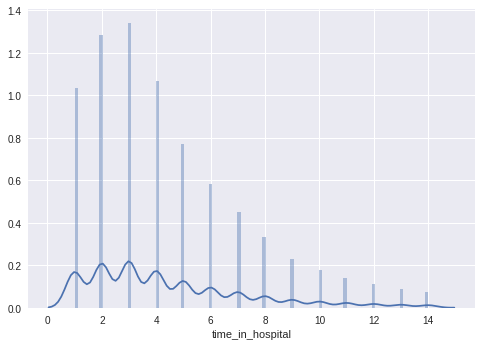

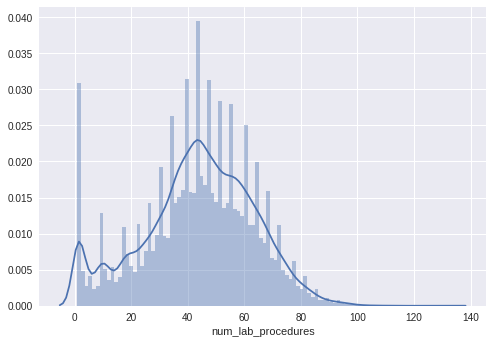

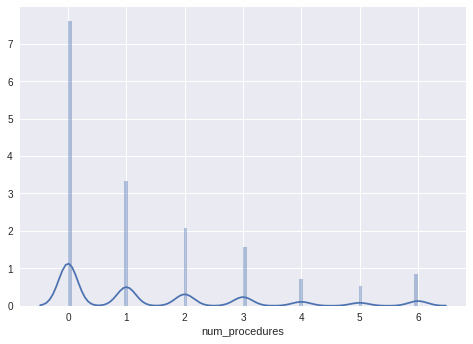

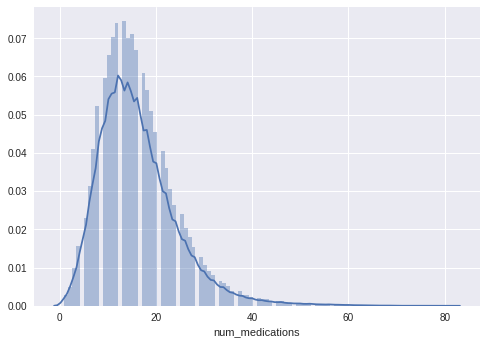

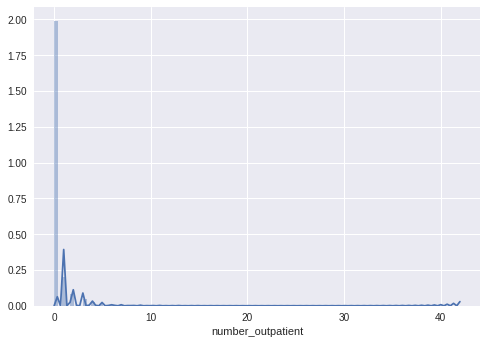

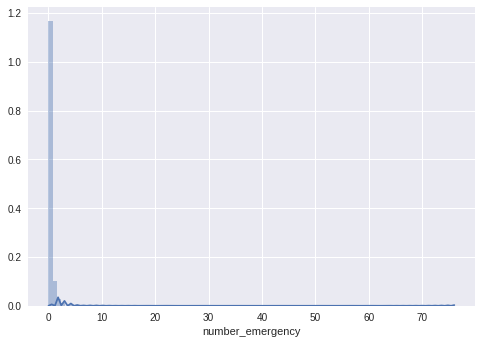

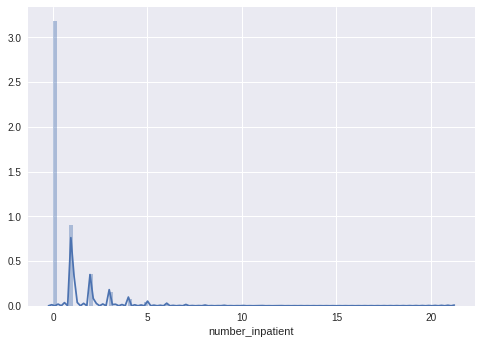

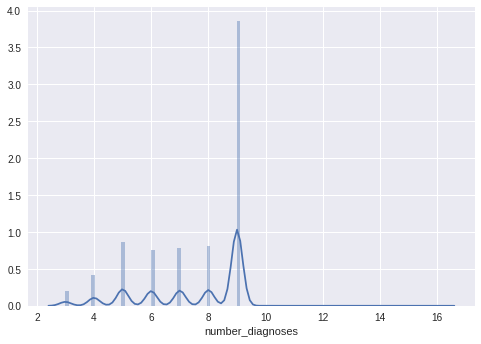

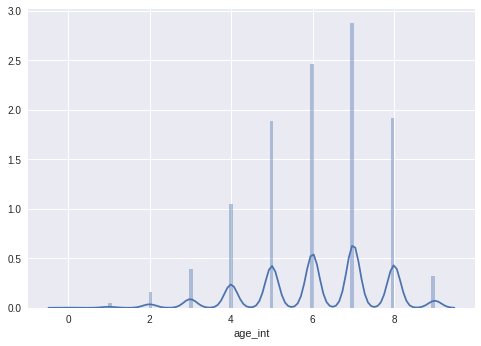

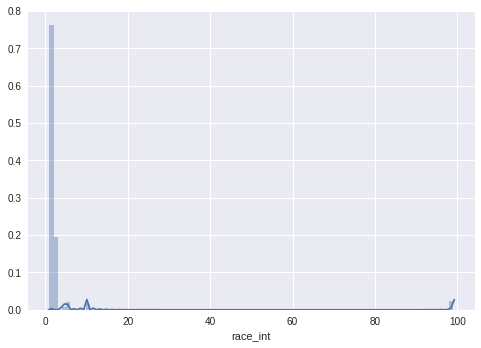

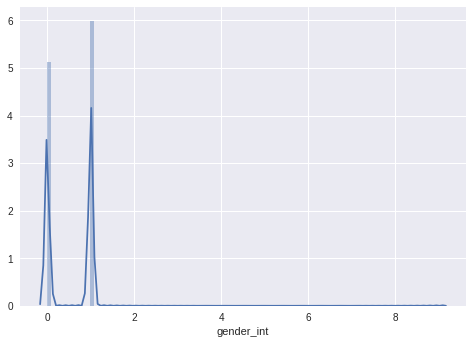

In [0]:
for x in columnas_no_categoricas_limp:
    sns.distplot(df_diabetes[x],bins=100)
    plt.show()

In [0]:
#Funcion test de Tukey 
def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[25,75])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    df_out=df[((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]
    return df_out
  #el primer signo ~ siginfica que me quedo con todo lo contrario a lo que le digo dentro de la condicion


In [0]:
#Aplicamos el Test de Tukey a las 4 variables que por el analisis de distribución creemos que tienen valores atípicos.
#No eliminamos los registros si no que nos creamos un nuevo dataframe con todos los registros outliers NO duplicados
columnas_out=['num_medications', 'number_outpatient',	'number_emergency',	'number_inpatient']
df_outlier_total=pd.DataFrame()
for x in columnas_out:
  df_outlier = tukey_outliers(df_diabetes,x,extreme=True)
  df_outlier_total=pd.concat([df_outlier_total,df_outlier], axis=0, join='outer')

df_outlier_total=df_outlier_total.drop_duplicates()

In [0]:
df_outlier_total.shape

(23118, 56)

In [0]:
# Si quisieramos cambiar alguno de los valores de los outliers.

# df_diabetes.loc[df_diabetes['number_emergency'] > 10, 'number_emergency'] = 10



### Crear variables dummy en caso que sea conveniente



### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

In [0]:
df_diabetes.dtypes

encounter_id                  int64 
patient_nbr                   int64 
race                          object
gender                        object
age                           object
weight                        object
admission_type_id             int64 
discharge_disposition_id      int64 
admission_source_id           int64 
time_in_hospital              int64 
payer_code                    object
medical_specialty             object
num_lab_procedures            int64 
num_procedures                int64 
num_medications               int64 
number_outpatient             int64 
number_emergency              int64 
number_inpatient              int64 
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses              int64 
max_glu_serum                 object
a1cresult                     object
metformin                     object
repaglinide                   object
nateglinide                   object
c

In [0]:
# aggregamos el df para ver si valores que siempre deberían ser iguales, no lo son.
df_agg=df_diabetes.groupby(['patient_nbr']).agg({'race':'nunique', 'gender':'nunique'})

In [0]:
# Enocntramos 207 regustros con más de una raza
df_agg[df_agg['race']>1].count()

In [0]:
# Enocntramos 207 regustros con más de un sexo
df_agg[df_agg['gender']>1].count()

In [0]:
#ejemplo de más de una raza
df_agg[df_agg['race']>1].head()

In [0]:
#ejemplo de más de una raza en el df original. ¿Podemos sacar alguna conclusión o modificar algún dato? Other podría ser modificado
df_diabetes.loc[df_diabetes['patient_nbr']==107849052]



### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear



# Exploratory Data Analysis



### Crear la matriz de correlación

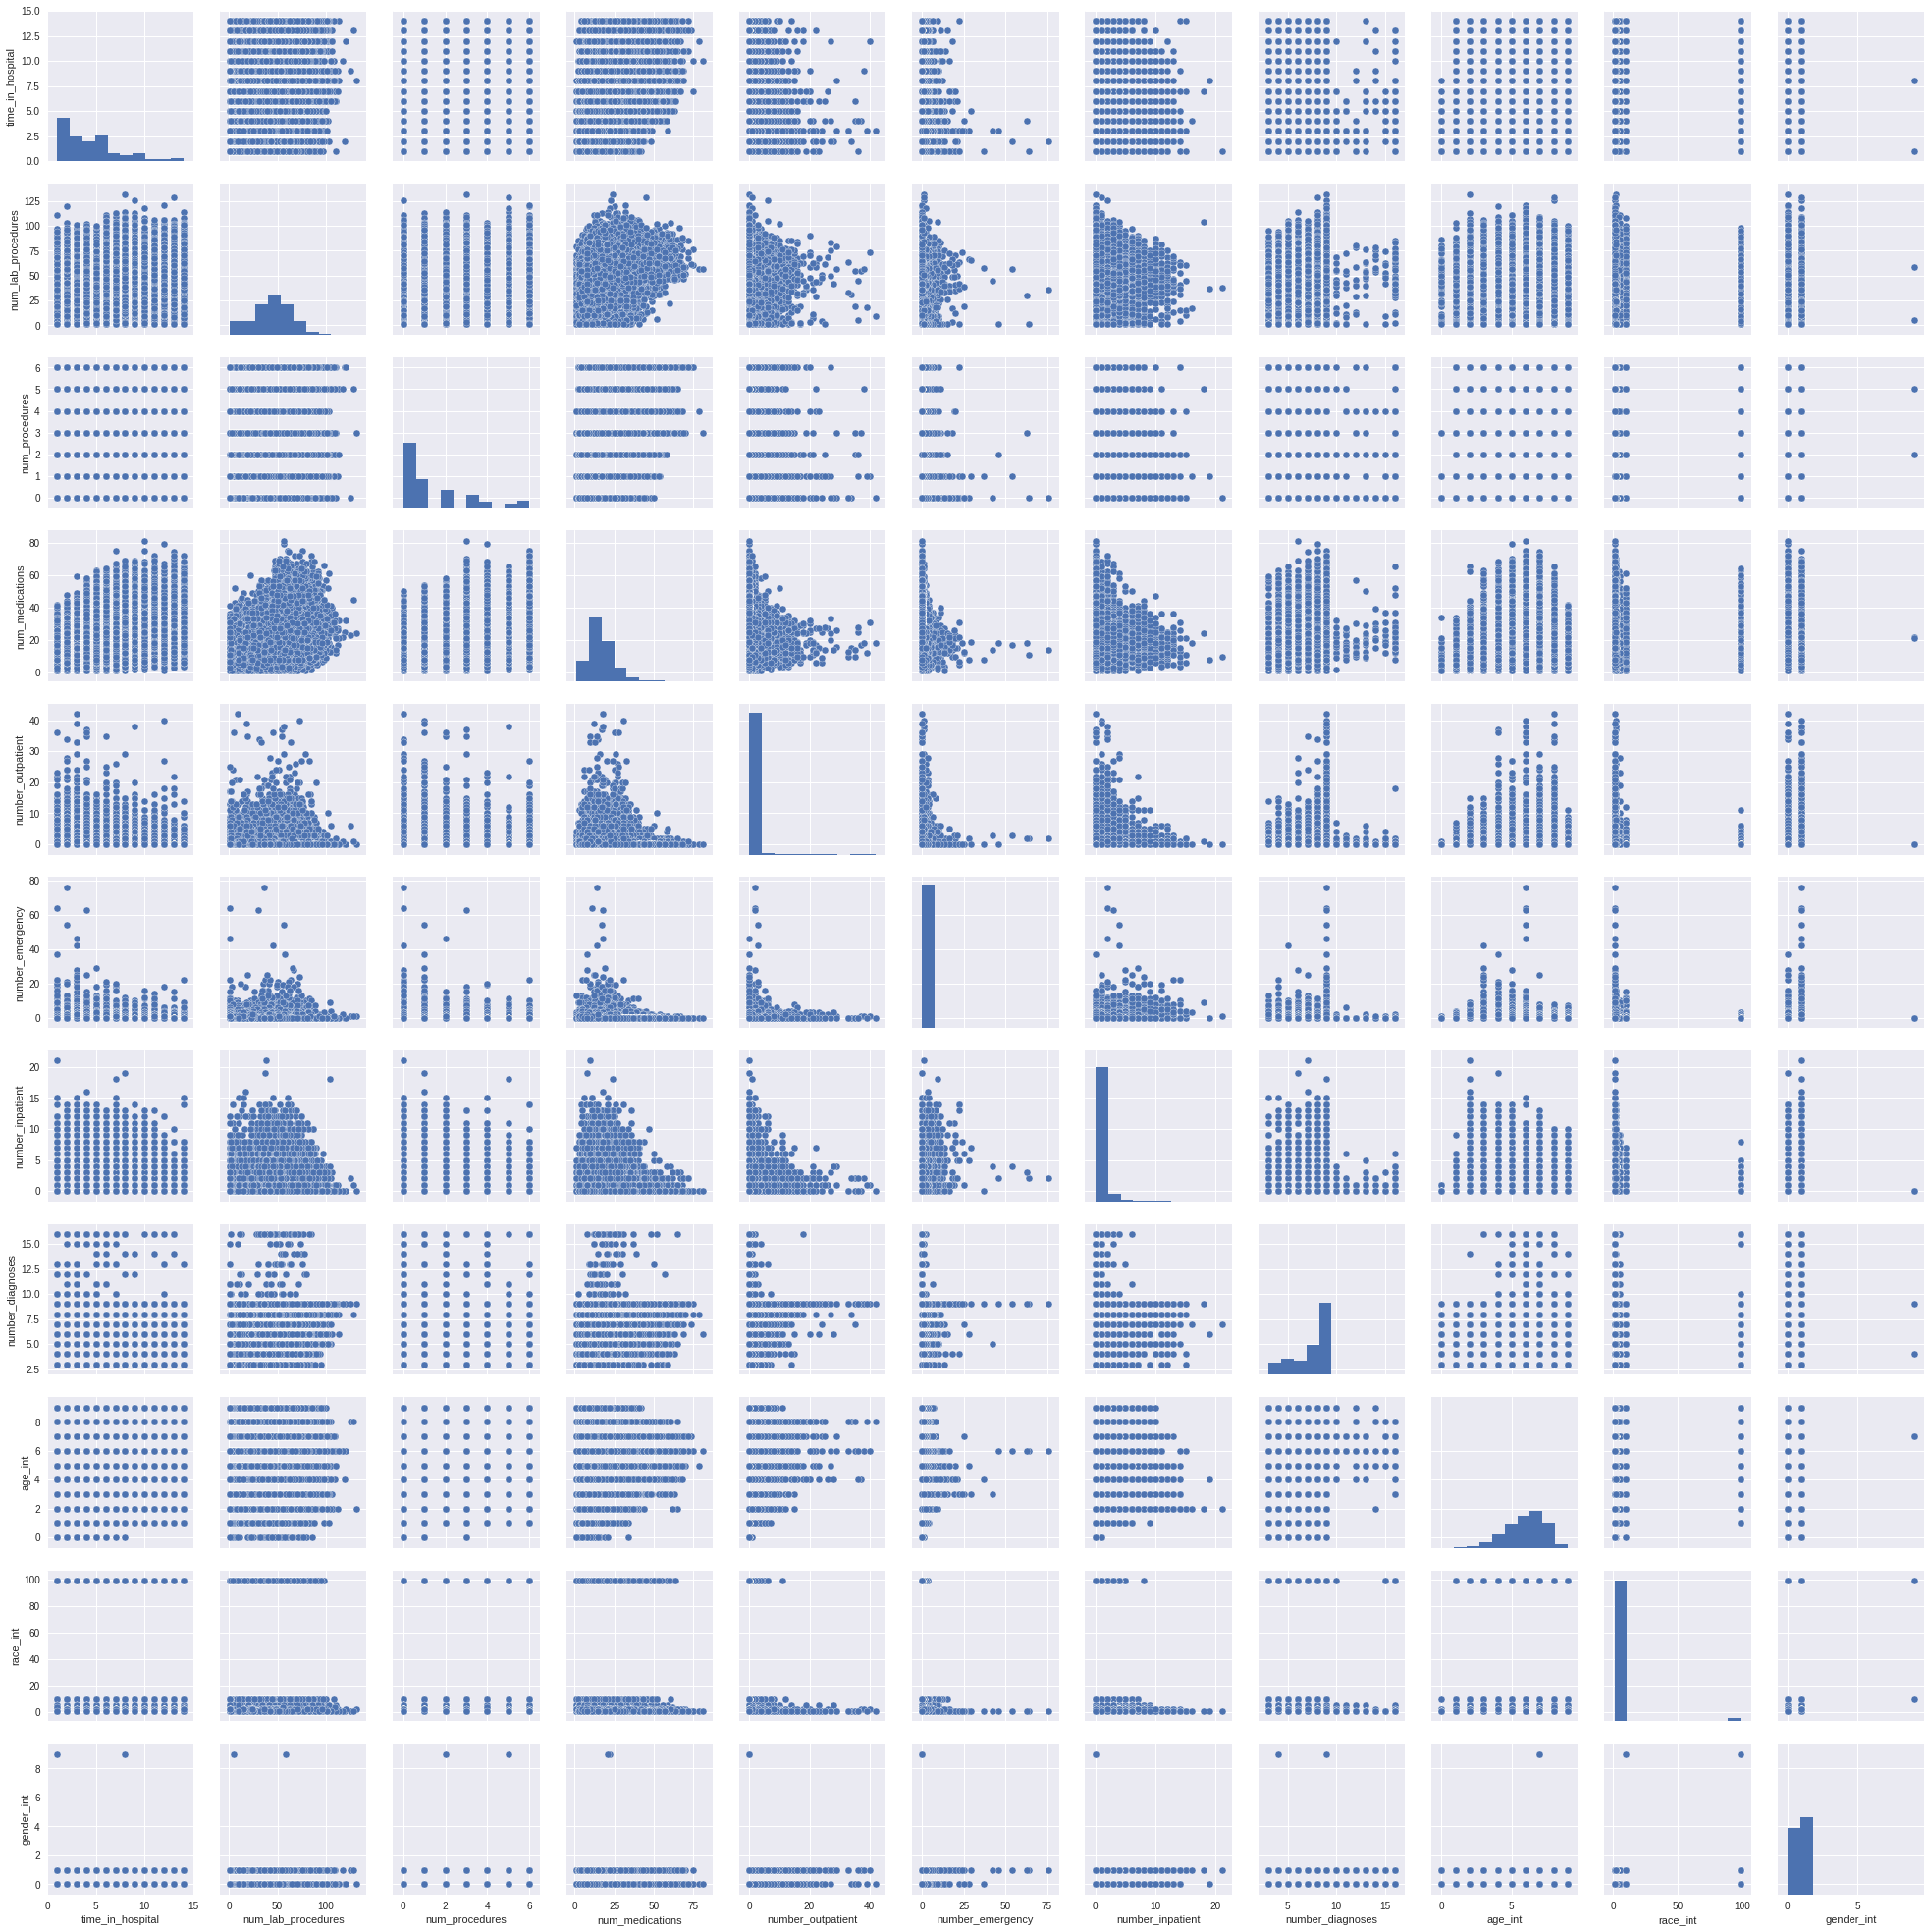

In [0]:
sns.pairplot(df_diabetes[columnas_no_categoricas_limp])

In [0]:
matriz_corr = df_diabetes[columnas_no_categoricas_limp].corr()
matriz_corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_int,race_int,gender_int
time_in_hospital,1.000000,0.333036,0.200125,0.477275,-0.008289,-0.007812,0.068214,0.210299,0.092230,-0.004980,0.026548
num_lab_procedures,0.333036,1.000000,0.060827,0.270775,-0.007806,-0.003856,0.042766,0.153093,0.018247,0.008297,0.001702
num_procedures,0.200125,0.060827,1.000000,0.386691,-0.028449,-0.038357,-0.070138,0.059856,-0.049892,-0.002879,-0.060611
num_medications,0.477275,0.270775,0.386691,1.000000,0.041805,0.012440,0.062188,0.243862,0.017867,-0.005449,0.019871
number_outpatient,-0.008289,-0.007806,-0.028449,0.041805,1.000000,0.091304,0.108087,0.092648,0.022552,-0.021898,0.009051
number_emergency,-0.007812,-0.003856,-0.038357,0.012440,0.091304,1.000000,0.262270,0.057328,-0.088402,-0.023542,0.018214
number_inpatient,0.068214,0.042766,-0.070138,0.062188,0.108087,0.262270,1.000000,0.108183,-0.042465,-0.040262,0.013789
number_diagnoses,0.210299,0.153093,0.059856,0.243862,0.092648,0.057328,0.108183,1.000000,0.198184,-0.062786,-0.000859
age_int,0.092230,0.018247,-0.049892,0.017867,0.022552,-0.088402,-0.042465,0.198184,1.000000,-0.002340,0.053358
race_int,-0.004980,0.008297,-0.002879,-0.005449,-0.021898,-0.023542,-0.040262,-0.062786,-0.002340,1.000000,-0.009651




### Pintar la matriz de correlación

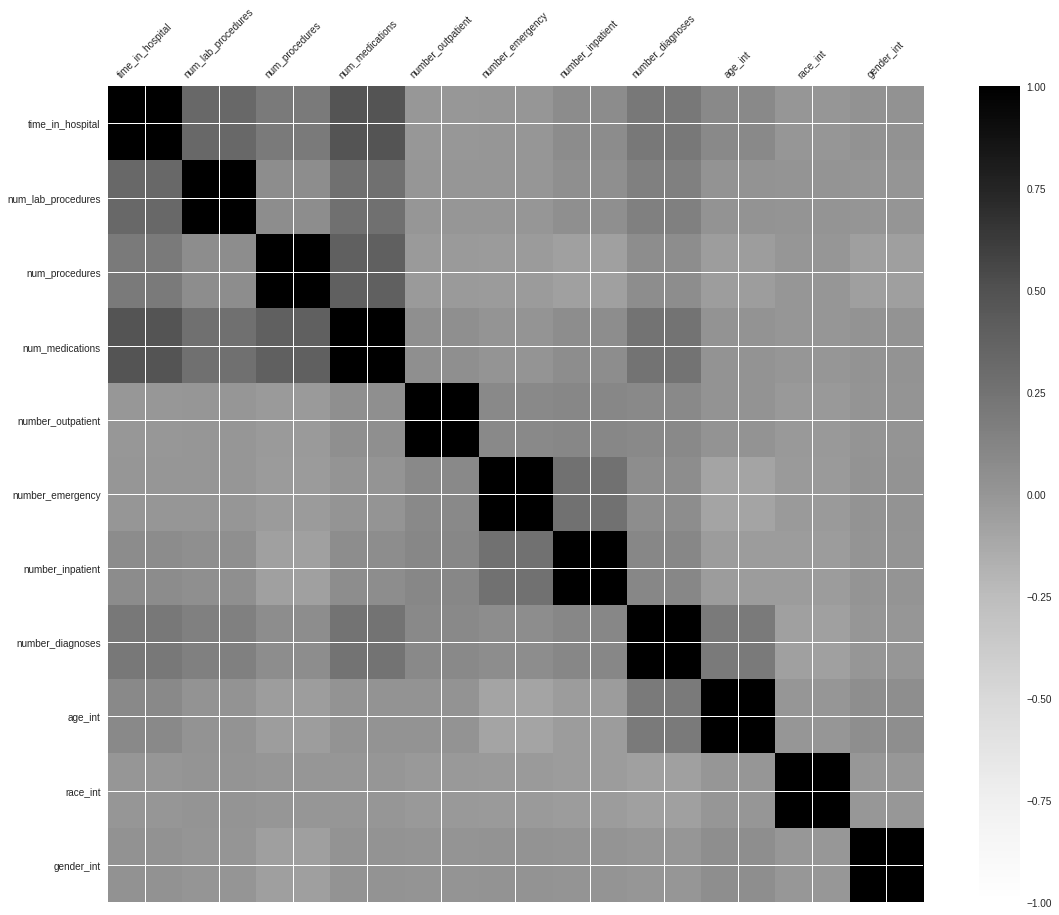

In [0]:
# plot matriz de correlación
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
cax = ax.matshow(matriz_corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,11,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columnas_no_categoricas_limp)
plt.xticks(rotation=45)
ax.set_yticklabels(columnas_no_categoricas_limp)
plt.show()
#El mayor nivel de correlación se observa entre la variable time_in_hospital y num_medications con un coeficiente del 0.47, seguido de correlaciones muy défiles con num_lab_procedures (.33) y number_diagnoses (.21). 
#Correlación también débil  del 0.38 entre num_medications y num_procedures y del 0.24 entre number_diagnoses y num_medications.
#En el resto no cabe destacar correlación alguna.

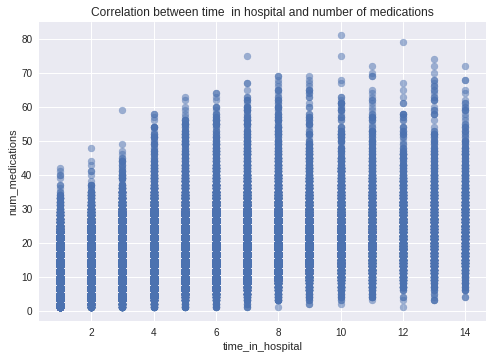

In [0]:
plt.scatter(df_diabetes['time_in_hospital'], df_diabetes['num_medications'], alpha=0.5)
plt.xlabel('time_in_hospital')
plt.ylabel('num_medications')
plt.title('Correlation between time  in hospital and number of medications')
plt.show()
#Conclusión: El número de num de medicaciones crece con el tiempo pasado en el hospital

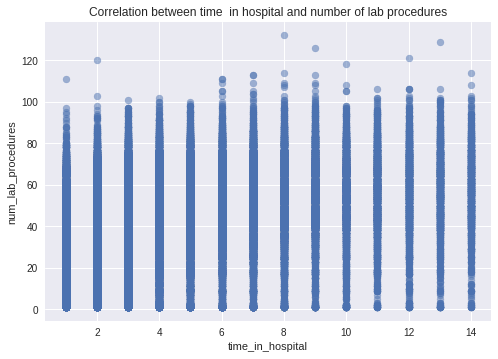

In [0]:
plt.scatter(df_diabetes['time_in_hospital'], df_diabetes['num_lab_procedures'], alpha=0.5)
plt.xlabel('time_in_hospital')
plt.ylabel('num_lab_procedures')
plt.title('Correlation between time  in hospital and number of lab procedures')
plt.show()
#Conclusión: El número de num_lab_procedures no depende del tiempo pasado en el hospital

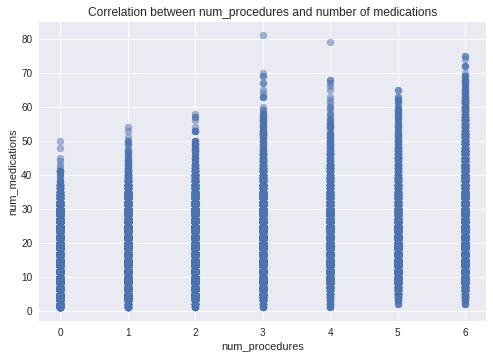

In [0]:
plt.scatter(df_diabetes['num_procedures'], df_diabetes['num_medications'], alpha=0.5)
plt.xlabel('num_procedures')
plt.ylabel('num_medications')
plt.title('Correlation between num_procedures and number of medications')
plt.show()
#Conclusión: El número de num de medicaciones crece con el número de procedimientos



### Determinar qué par de variables están correlacionadas